# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau : exemples de référence

- Construction des courbes de niveau

  - Méthode de Newton

  - Génération des points

  - Bouclage et auto-intersection 

- Calcul de l'aire d'un ensemble de sous-niveau

  - Méthode des carrés

  - Méthodes des triangles

## Préambule

### Dépendances logicielles 

In [1]:
# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

from itertools import product

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [2]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [3]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

Exemples d'usage :

In [4]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

g = grad_f(1.0, 0.0) # array([1., 2.])
#g = autograd.grad
#print(g(f,0)(0.0,0.0))

In [5]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

## Ensembles de niveau : exemples de référence

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x,y) \in \mathbb{R}^2 \; | \; f(x, y) = c\}.
$$


On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [6]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [7]:
def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    return 3.0 * x * x - 2.0 * x * y + 3.0 * y * y 

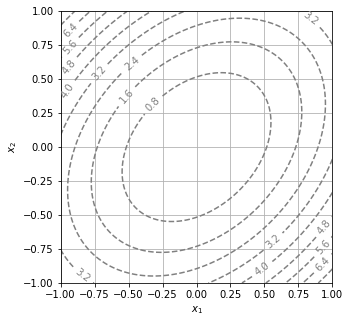

In [8]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x,y) \in \mathbb{R}^2 \mapsto (x - 1)^2 + (x - y^2)^2
$$

In [9]:
def f2(x, y):
    return (x - 1)**2 + (x - y**2)**2

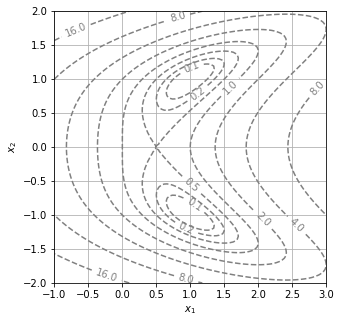

In [10]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [11]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

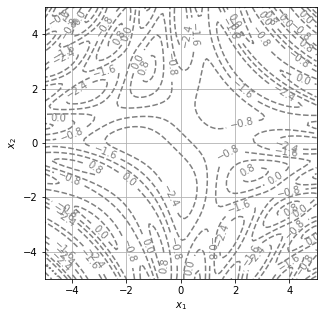

In [12]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x,y) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $(x_0,y_0) \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

**Question** L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [13]:
N = 100
eps = 1e-8

**Question** Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [14]:
def Newton(F, x0, y0, eps=eps, N=N):
    J_F = J(F)
    L = []
    coord = []
    for i in range(N):
        J_inv = np.linalg.inv(J_F(x0,y0))
        x, y = - np.dot(J_inv, F(x0, y0)) + (x0, y0)
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return x, y, coord
        x0, y0 = x, y
        #Pour l'illustration :
        L.append([x0,y0])
        coord = np.array(L)
    else:
        raise ValueError(f"no convergence in {N} steps.")

**Question** Tester votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x, y)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x = y$ en utilisant le point $(0.8, 0.8)$. Puis de faire varier le point de référence, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

La solution est : x = 0.4472135954999579, y = 0.4472135954999579. Convergence en 4 étapes.


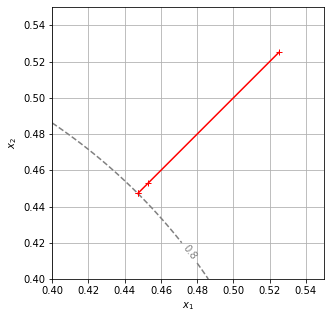

In [15]:
#Test sur f1

def F1(x,y):
    return np.array([f1(x,y)-0.8,x-y])

x,y,coord = Newton(F1, 0.8, 0.8, eps, N)

print(f"La solution est : x = {x}, y = {y}. Convergence en {len(coord)} étapes.")


display_contour(
    f1, 
    x=np.linspace(0.4, 0.55, 100), 
    y=np.linspace(0.4, 0.55, 100), 
    levels=[0.8]
)


X = coord[:, 0]
Y = coord[:, 1]
plt.plot(X, Y, 'r+-')

plt.show()

La solution est : x = 1.3660254037844386, y = 0.0. Convergence en 3 étapes.


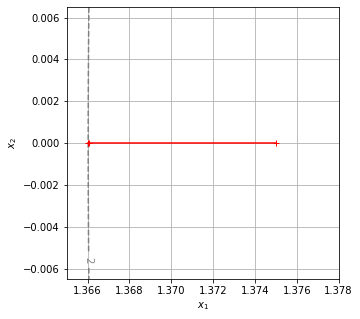

In [16]:
#Test sur f2

def F2(x,y):
    return np.array([f2(x, y) - 2.0, y])

x, y, coord2 = Newton(F2, 1.5, 0.0, eps, N)

#on se sert du point (1.5, 0) et on veut chercher la courbe de niveau f^{-1}(2) horizontalement

print(f"La solution est : x = {x}, y = {y}. Convergence en {len(coord2)} étapes.")

display_contour(
    f2, 
    x=np.linspace(1.365, 1.378, 100), 
    y=np.linspace(-0.0065, 0.0065, 100), 
    levels=[2.0]
)


X2 = coord2[:, 0]
Y2 = coord2[:, 1]
plt.plot(X2,Y2, 'r+-')
plt.show()

La solution est : x = 1.925529760022187, y = 1.925529760022187. Convergence en 3 étapes.


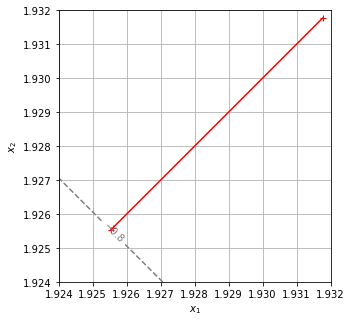

In [17]:
#Test sur f3


def F3(x,y):
    return np.array([f3(x, y) + 0.8, y-x])

x, y, coord3 = Newton(F3, 2.0, 2.0, eps, N)

print(f"La solution est : x = {x}, y = {y}. Convergence en {len(coord3)} étapes.")


display_contour(
    f3, 
    x=np.linspace(1.924, 1.932, 100), 
    y=np.linspace(1.924, 1.932, 100), 
    levels=[-0.8]
)

X3 = coord3[:, 0]
Y3 = coord3[:, 1]
plt.plot(X3,Y3, 'r+-')
plt.show()

### Génération des points

**Question** Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille $2 \times N$ contenant les coordonnées des points correspondants.

In [18]:
#On rebaptise N en M (conflit avec le N de la méthode de Newton)

def level_curve(f, x0, y0, c, delta=1e-1, M=1000, eps=eps):
    liste = []
    liste.append((x0, y0))
    for i in range(M-1):
        grad_f = grad(f)
        normale = grad_f(x0,y0)
        normale_unit = normale/np.linalg.norm(normale)
        orthonormale = np.array([normale_unit[1], -normale_unit[0]])
        x_, y_ = np.array([x0,y0]) + delta*orthonormale
        def F_(x, y):
            return np.array([f(x,y)-c, (x-x0)**2 + (y-y0)**2 - delta**2])
        x1, y1,_ = Newton(F_, x_, y_, eps, N)
        liste.append((x1, y1))
        x0, y0 = x1, y1
    coordonnees = np.array(liste)
    return coordonnees 

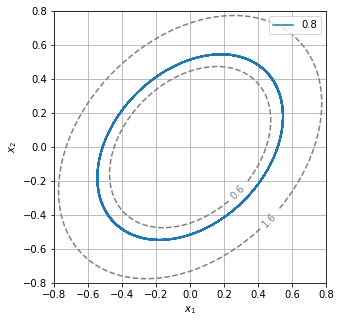

In [19]:
#Test sur f1

def F1(x,y):
    return np.array([f1(x,y)-0.8,x-y])

x0, y0, _ = Newton(F1, 0.8, 0.8, eps, N)

display_contour(
    f1, 
    x=np.linspace(-0.8, 0.8, 100), 
    y=np.linspace(-0.8, 0.8, 100), 
    levels=[0.6, 1.6]
)




courbe1 = level_curve(f1, x0, y0, 0.8)
X1 = courbe1[:, 0]
Y1 = courbe1[:, 1]
plt.plot(X1, Y1, label='0.8')
plt.legend()
plt.show()

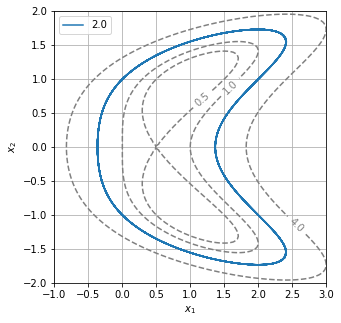

In [20]:
#Test sur f2

def F2(x,y):
    return np.array([f2(x, y) - 2.0, y])

x0, y0,_ = Newton(F2, 1.5, 0.0, eps, N)

#on se sert du point (1.5, 0) et on veut chercher la courbe de niveau f^{-1}(2) horizontalement


display_contour(
    f2, 
    x=np.linspace(-1, 3, 100), 
    y=np.linspace(-2, 2, 100), 
    levels=[0.5, 1, 4]
)



courbe2 = level_curve(f2, x0, y0, 2.0)
X2 = courbe2[:, 0]
Y2 = courbe2[:, 1]
plt.plot(X2,Y2, label='2.0')
plt.legend()
plt.show()

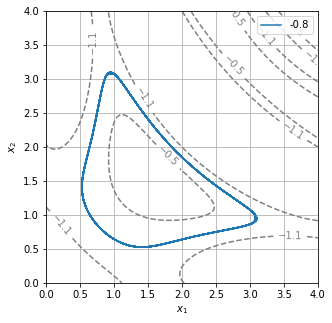

In [21]:
#Test sur f3


def F3(x,y):
    return np.array([f3(x, y) + 0.8, y-x])

x0, y0,_ = Newton(F3, 2.0, 2.0, eps, N)


display_contour(
    f3, 
    x=np.linspace(0.0, 4, 100), 
    y=np.linspace(0, 4, 100),
    levels=[-1.1, -0.5]
)

courbe3 = level_curve(f3, x0, y0, -0.8)
X3 = courbe3[:, 0]
Y3 = courbe3[:, 1]
plt.plot(X3, Y3, label='-0.8')
plt.legend()
plt.show()

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

**Question** Proposer une nouvelle implémentation de `level_curve` qui évite ce problème. 

In [22]:
#On considère qu'on a fait un "tour complet" lorsque la somme des angles des veteurs tangents à la courbe
#(pris entre -pi et pi) s'annule
#On ajoute donc un compteur de cette somme. Le critère de retour sera vérifié si cette somme s'approche de 0
#à une distance d'un paramètre alpha très petit.
"""
alpha = 1e-1

def level_curve_corr(f, x0, y0, c, delta=0.1, M=1000, eps=eps, alpha=alpha):
    liste = []
    liste.append((x0, y0))
    #Correction :
    somme_norm = 0
    i = 0
    while ((abs(somme_norm) > alpha) and i < M - 1) or i == 0:
        i += 1
        grad_f = grad(f)
        normale = grad_f(x0,y0)
        normale_unit = normale/np.linalg.norm(normale)
        orthonormale = np.array([normale_unit[1], -normale_unit[0]])
        x_, y_ = np.array([x0,y0]) + delta*orthonormale
        def F_(x, y):
            return np.array([f(x,y)-c, (x-x0)**2 + (y-y0)**2 - delta**2])
        x1, y1, _ = Newton(F_, x_, y_, eps, N)
        liste.append((x1, y1))
        #Modif :
        somme_norm += np.angle(x1-x0 + 1j*(y1-y0))
        print(somme_norm)
        x0, y0 = x1, y1
    print(f"Nombre de points : {len(liste)}")
    coord = np.array(liste)
    return coord
"""
#Echec de la méthode des tangeantes
#On considère que le système boucle dès que le dernier point sorti par la méthode est situé dans la boule
#de centre (x0, y0) et de rayon delta. Pour ce faire, il est important de choisir un delta petit.
#Cette méthode peut empêcher de voir la totalité de la courbe : elle s'arrête au premier passage de la courbe
#dans la boule de rayon delta.


def level_curve_corr(f, x0, y0, c, delta=0.1, M=1000, eps=eps):
    liste = []
    liste.append((x0, y0))
#Correction :
    x_depart, y_depart = x0, y0
    i = 0
    delta_eps2 = (delta+eps)**2
    distance2 = delta_eps2 + 1
#Idem :
    while (distance2 > delta_eps2 and  i < M - 1) or i < 2:
        i += 1
        grad_f = grad(f)
        normale = grad_f(x0,y0)
        normale_unit = normale/np.linalg.norm(normale)
        orthonormale = np.array([normale_unit[1], -normale_unit[0]])
        x_, y_ = np.array([x0,y0]) + delta*orthonormale
        def F_(x, y):
            return np.array([f(x,y)-c, (x-x0)**2 + (y-y0)**2 - delta**2])
        x1, y1, _ = Newton(F_, x_, y_, eps, N)
        liste.append((x1, y1))
#Correction :
        distance2 = (x1 - x_depart)**2 + (y1 - y_depart)**2
        x0, y0 = x1, y1
    print(f"Nombre de points (pour delta = {delta}): {len(liste)}")
    coord = np.array(liste)
    return coord

**Question** Valider graphiquement le résultat au moyen des exemples de référence.

Nombre de points (pour delta = 0.1): 35


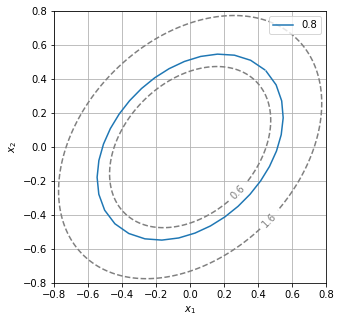

In [23]:
#Test sur f1

def F1(x,y):
    return np.array([f1(x, y) - 0.8, y - x])

x0, y0,_ = Newton(F1, 0.8, 0.8, eps, N)


display_contour(
    f1, 
    x=np.linspace(-0.8, 0.8, 100), 
    y=np.linspace(-0.8, 0.8, 100), 
    levels=[0.6, 1.6]
)

courbe1 = level_curve_corr(f1, x0, y0, 0.8)
X1 = courbe1[:, 0]
Y1 = courbe1[:, 1]
plt.plot(X1,Y1, label='0.8')
plt.legend()
plt.show()

Nombre de points (pour delta = 0.1): 114


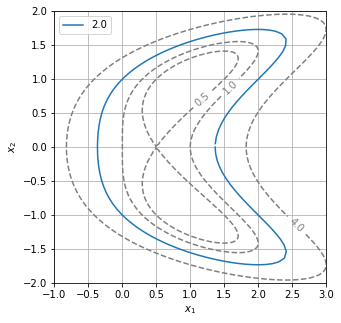

In [24]:
#Test sur f2

def F2(x,y):
    return np.array([f2(x, y) - 2.0, y])

x0, y0,_ = Newton(F2, 1.5, 0.0, eps, N)


display_contour(
    f2, 
    x=np.linspace(-1, 3, 100), 
    y=np.linspace(-2, 2, 100), 
    levels=[0.5, 1, 4]
)


courbe2 = level_curve_corr(f2, x0, y0, 2.0)
X2 = courbe2[:, 0]
Y2 = courbe2[:, 1]
plt.plot(X2,Y2, label='2.0')
plt.legend()
plt.show()

Nombre de points (pour delta = 0.1): 80


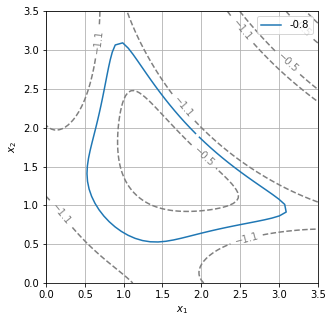

In [25]:
#Test sur f3


def F3(x,y):
    return np.array([f3(x, y) + 0.8, y-x])

x0, y0,_ = Newton(F3, 2.0, 2.0, eps, N)



display_contour(
    f3, 
    x=np.linspace(0.0, 3.5, 100), 
    y=np.linspace(0, 3.5, 100),
    levels=[-1.1, -0.5]
)


courbe3 = level_curve_corr(f3, x0, y0, -0.8)
X3 = courbe3[:, 0]
Y3 = courbe3[:, 1]
plt.plot(X3, Y3, label='-0.8')
plt.legend()
plt.show()

# Calcul de l'aire d'un ensemble de sous-niveau
On cherche à estimer l'aire d'un ensemble délimité par une courbe fermée, approchée par une ligne brisée comme les ensemble de niveau décrits précédemment.

## Méthode des carrés
Considérons un tel ensemble $K$ décrit par l'équation $f(x_1,x_2)\leq c$.
Une première approche grossière, sans utiliser la description de la frontière obtenue précédemment, consiste à plonger l'ensemble  $K$ dans un domaine de forme simple (disons un carré pour fixer les idées), donc d'aire connue, à recouvrir le carré d'une grille uniforme constituée de petites cellules carrée de taille $h\times h$,  et d'estimer l'aire en fonction de la proportion du nombre de cellules dont le centre est  dans $K$. On obtient ainsi une approximation $A_h$ de l'aire de $K$. Lorsque $h$ tend vers $0$, on peut  s'attendre à ce que $A_h$ tende effectivement vers l'aire $A$ de $K$. 

**Question**  Coder une fonction `area_squares(f,c,h)` qui renvoie l'aire approchée de l'ensemble de sous-niveau de $f$ associée à $c$ à l'aide de la méthode des carrés pour un pas $h$. Appliquer cette méthode à l'estimation  de l'aire du disque unité et étudier numériquement le comportement de  $|A_h - A|$ quand $h$ tend vers $0$. (On pourra tracer une courbe de l'erreur fonction de $h$ en échelle log-log).

In [26]:
#from itertools import product

def area_squares(f, c, h, cote_carre):
    """
    # Recherche de la taille du carré, si inconnue et donc pas fournie en argument
    test = False
    cote = 1
    while not test:
        #print('avant')
        cote += 1
        frontiere_carre_horiz = [(i*h, signe*cote/2) for i in range(-int(cote/(2*h)), int(cote/(2*h))+1) for signe in [-1,1]]
        #print('après')
        frontiere_carre_vert = [(signe*cote/2, j*h) for j in range(-int(cote/(2*h)), int(cote/(2*h))+1) for signe in [-1, 1]]
#on teste ainsi si K est dans une forme qui s'approche d'un carré ; le test est échatillonné sur des points
# du perimètre situés à intervalles réguliers h, ie notre méthode détecte à h près les formes.
        frontiere_carre = np.array(frontiere_carre_horiz + frontiere_carre_vert)
        test = False in np.greater(f(frontiere_carre[:,0], frontiere_carre[:,1]), c)
    cote_carre = cote
    """
    nb_centres = 0
    borne = int(cote_carre/(2*h)) + 1
    liste_centres = [(i*h, j*h) for i in range(- borne - 1, borne +1) for j in range(-borne - 1, borne + 1)]
    for centre in liste_centres:
        if f(centre[0],centre[1]) <= c:
            nb_centres += 1
    return h**2*nb_centres

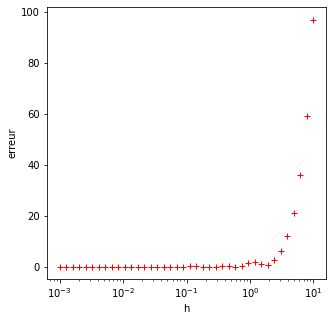

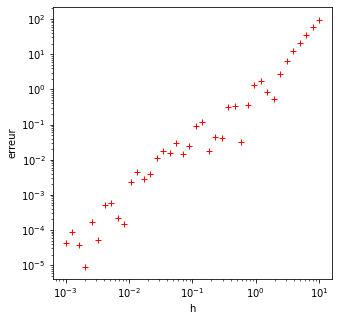

In [27]:
##TEST DISQUE UNITE

from numpy import cos, sin, pi, vectorize

def f_cercle(x, y):
    return x**2 + y**2


HH = np.logspace(-3,1, 40)
erreur = [abs(area_squares(f_cercle, 1, hh, 2.1) - pi) for hh in HH]



plt.plot(HH, erreur, 'r+')
plt.xscale('log')
plt.xlabel('h'), plt.ylabel('erreur')
plt.show()

plt.plot(HH, erreur, 'r+')
plt.xscale('log'), plt.yscale('log')
plt.xlabel('h'), plt.ylabel('erreur')
plt.show()


In [28]:
#On observe une convergence relativement rapide en h.

**Question**  Expliquer comment cette approche peut être modifiée pour obtenir un encadrement de l'aire recherchée. 
Appliquer cette approche à l'ensemble de sous niveau considéré précédemment, pour en donner un encadrement à $10^{-2}$ près.


In [29]:
## On souhaite obtenir un encadrement de l'aire
# Pour ce faire, on part de l'ensemble m formé par les carrés dont les centres sont dans K, pour h donné.
# On fait l'hypothèse que h est suffisament petit de telle sorte que si le centre d'un petit carré est dans K,
# alors, tout le carré y soit aussi (autrement dit, on réduit h pour éviter les formes type rectangle très fin
# contenant le centre du carré).
# Dès lors m est inclus dans K et donc l'aire de m constitue notre minoration.
# Pour obtenir la majoration, on va "encadrer" m par des carrés. On forme alors M, en ajoutant à m tous les
# carrés de côté h, partageant une arrête au moins avec les carrés de m.
# Ainsi, on a la frontière de K incluse dans M, et donc l'aire de M consitue notre majoration.
# Reste à diminuer h jusuq'à obtenir une différence entre les aires de M et de m inférieure à notre erreur
# maximale souhaitée.

In [30]:
def area_squares_enc(f, c, erreur_lim, cote):
    """
    #Au cas où cote n'est pas connu/fourni
    test = False
    cote = 1
    h = 1
    while not test:
        cote += 1
        frontiere_carre_horiz = [(i*h, signe*cote/2) for i in range(-int(cote/(2*h)), int(cote/(2*h))+1) for signe in [-1,1]]
        frontiere_carre_vert = [(signe*cote/2, j*h) for j in range(-int(cote/(2*h)), int(cote/(2*h))+1) for signe in [-1, 1]]
        frontiere_carre = np.array(frontiere_carre_horiz + frontiere_carre_vert)
        test = False in np.greater(f(frontiere_carre[:,0], frontiere_carre[:,1]), c)
    #on vient de trouver le cote, maintenant, on débute les modifications :
    """
    h=1
    erreur = erreur_lim + 1
    erreur_lim_fois_2 = erreur_lim*2
    while erreur > erreur_lim_fois_2:
        borne = int(cote/(2*h)) + 1
        liste_indices_centres = [[i, j] for i in range(-borne-1,borne+1) for j in range(-borne - 1, borne + 1)]
        indices_m = []
        for indices in liste_indices_centres:
            if f(indices[0]*h, indices[1]*h) <= c:
                indices_m.append(indices)
        aire_m = len(indices_m)*h**2
        indices_M = indices_m
        lignes_m = [couple[0] for couple in indices_m]
        #print(lignes_m)
        #print(max(lignes_m))
        colonnes_m = [couple[1] for couple in indices_m]
        for i in range(min(lignes_m), max(lignes_m) + 1):
        #i parcourt toutes les lignes du quadrillages de m
            ligne_i_de_m = [ b for (a, b) in indices_m if a==i]
            indices_M.append((i, min(ligne_i_de_m) - 1))
            indices_M.append((i, max(ligne_i_de_m) + 1))
        for j in range(min(colonnes_m), max(colonnes_m)):
        #j parcourt toutes les colonnes du quadrillages de m
            colonne_j_de_m = [a for (a, b) in indices_m if b==j]
            mini = (min(colonne_j_de_m) - 1, j)
            maxi = (max(colonne_j_de_m) + 1, j)
            if mini not in indices_M:
                indices_M.append(mini)
            if maxi not in indices_M:
                indices_M.append(maxi)
        aire_M = len(indices_M) * h**2
        erreur = aire_M - aire_m
        h /=2
    return (aire_M + aire_m) /2

In [31]:
pi = area_squares_enc(f_cercle, 1,1e-2, 2.1) 

print(f"On trouve un valeur de : pi = {pi} ; soit une erreur de {abs(np.pi - pi)}.")

#Ca marche, mais c'est un peu long...

On trouve un valeur de : pi = 3.1491165161132812 ; soit une erreur de 0.007523862523488134.


# Méthode des triangles
On suppose maintenant que l'on dispose d'une description approchée de la frontière de l'ensemble $K$, sous la forme d'une suite "circulaire"  de points consécutifs:
$$
(x_0,y_0), (x_1,y_1), \dots, (x_N,y_N)= (x_0,y_0),
$$
par exemple la sortie de ``level_curve``.
On note $z_i = (x_i,y_i)$. Conformément à ce qui précède, on considére que la courbe fermée est décrite dans le sens anti-trigonométrique (sens des aiguilles d'une montre). On suppose dans un premier temps que l'ensemble $K$ est convexe. 
On se donne un point $p = (x_p,y_p)$ dans  l'intérieur de $K$, et l'on somme les aires des triangles $(p,z_{i+1},z_i)$. 
On obtient une approximation de l'aire de $K$, notée $B_N$.

**Question** Tester cette approche sur le disque unité. Etudier la convergence de $B_N$ vers $\pi$ lorsque la distance $\delta$ entre les points successifs de la courbe de niveau tend vers 0, et étudier numériquement la vitesse de cette convergence.  

In [32]:
def area_triangles(L, p):
    B_N = 0
    for i in range(len(L)-1):
        pzi = np.array([L[i][0] - p[0], L[i][1] - p[1]])
        pziplusun = np.array([L[i+1][0] - p[0], L[i+1][1] - p[1]])
        B_N += -np.cross(pzi, pziplusun)/2 #L'aire orientée du triange est définie comme la moitié
        # du produit scalaire (qui renvoie l'aire du parallélogramme formé par les vecteurs)
    avant_dernier = np.array([L[-2][0] - p[0], L[-2][1] - p[1]])
    dernier = np.array([L[-1][0] - p[0], L[-1][1] - p[1]])
    premier = np.array([L[0][0] - p[0], L[0][1] - p[1]])
    B_N += -np.cross(avant_dernier, dernier)/2
    B_N += -np.cross(dernier, premier)/2
    return B_N
    

In [33]:
N = 100

Nombre de points (pour delta = 0.001): 6284
Nombre de points (pour delta = 0.0026826957952797246): 2343
Nombre de points (pour delta = 0.0071968567300115215): 874
Nombre de points (pour delta = 0.019306977288832496): 326
Nombre de points (pour delta = 0.0517947467923121): 122
Nombre de points (pour delta = 0.13894954943731375): 46
Nombre de points (pour delta = 0.3727593720314938): 17
Nombre de points (pour delta = 1.0): 6


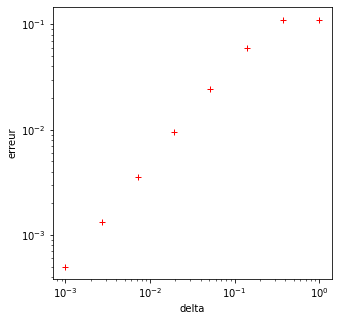

In [34]:
delta = np.logspace(-3,0, 8)

#L = level_curve_corr(f_cercle, 1.0, 0.0, 1.0, delta)
erreur = [abs(np.pi - area_triangles(l, (0.0,0.0)))
          for l in [level_curve_corr(f_cercle, 1.0, 0.0, 1.0, d, 100000)
                 for d in delta]]


plt.plot(delta, erreur, 'r+')
plt.xscale('log'), plt.yscale('log')
plt.xlabel('delta'), plt.ylabel('erreur')
plt.show()
#ATTENTION C'EST LONG

**Question** Vérifier que l'approche (on prendra garde à accepter le fait qu'il puisse y avoir, dans le calcul des différentes aires,  des triangles d'aire négative) donne des résultats pertinents même si le point $p$ est  à l'extérieur de $K$. Donner une explication à ce bon comportement.

Nombre de points (pour delta = 0.001): 6284
Nombre de points (pour delta = 0.01): 629
Nombre de points (pour delta = 0.1): 63
Nombre de points (pour delta = 1.0): 6


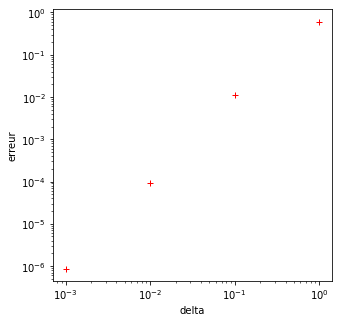

In [35]:
delta = np.logspace(-3,0, 4)

#L = level_curve_corr(f_cercle, 1.0, 0.0, 1.0, delta)
erreur = [abs(np.pi - area_triangles(l, (1.0,1.0)))
          for l in [level_curve_corr(f_cercle, 1.0, 0.0, 1.0, d, 100000)
                 for d in delta]]

plt.plot(delta, erreur, 'r+')
plt.xscale('log'), plt.yscale('log')
plt.xlabel('delta'), plt.ylabel('erreur')
plt.show()
#ATTENTION C'EST LONG

#La méthode marche toujours. Même si le point est à l'extérieur de K, les aires supplémentaires de la 
#partie qui se trouve en dehors de L à chaque tracé de triangle se compensent lorsqu'on fait le tour, 
#étant donné que les aires peuvent prendre des valeurs négatives et que la courbe est fermée.

**Question** Vérifier le bon comportement de la méthode dans le cas où l'ensemble $K$ n'est pas convexe. On pourra considérer par exemple la réunion de deux disques, tous deux décrits par leur frontière discrétisée parcourue dans le sans anti-trigonométrique.

In [36]:
N=1000
delta = 0.001

front_1 = level_curve_corr(f_cercle, 1.0, 0.0, 1.0, delta, 10000)
def f_cercle_2(x,y):
    return f_cercle(x - 5, y) #Cercle unité translaté, centré en (5,0)
front_2 = level_curve_corr(f_cercle_2, 6.0, 0.0, 1.0, delta, 10000)

front = np.array(front_1.tolist() + front_2.tolist())


print(f"L'erreur est de : {abs(2*np.pi - area_triangles(front, (0.0, 0.0)))}.")

Nombre de points (pour delta = 0.001): 6284
Nombre de points (pour delta = 0.001): 6284
L'erreur est de : 0.0029989521828044374.


**Question** En déduire une fonction `area_triangles(x,y)` qui évalue l'aire d'une surface de niveau décrite par un ensemble de points $(x_i,y_i)$ de la courbe de niveau. Appliquer cette approche à l'ensemble de sous-niveau considéré précédemment, et vérifier que les deux méthodes (carrés et triangles) donnent des résultats cohérents entre elles. 
Comparer les méthodes entre elles, en précisant les avantages et défauts relatifs de chacune d'elles. 
(On pourra appuyer la réponse sur des tests numériques ainsi que sur des arguments théoriques)

In [37]:
from time import time

x0, y0, _ = Newton(F1, 0.8, 0.8, eps, N)
courbe1 = level_curve_corr(f1, x0, y0, 0.8, delta=1e-2)
t_a = time()
t1 = area_triangles(courbe1, (0., 0.))
t_b = time()
t2 = area_squares(f1, 0.8, 1e-3, 2.1)
t_c = time()

print(f"Aire selon la méthode des triangles : {t1}. Aire selon la méthode des carrés : {t2}. Ecart relatif : {round((t1-t2)/t1*100,4)}% (par rapport à la méthode triangle)")

print(f"Durée du programme des triangles:{round(t_b-t_a,3)}s.  Durée du programme des carrés: {round(t_c-t_b,3)}s.")

Nombre de points (pour delta = 0.01): 342
Aire selon la méthode des triangles : 0.8916852971194663. Aire selon la méthode des carrés : 0.888579. Ecart relatif : 0.3484% (par rapport à la méthode triangle)
Durée du programme des triangles:(0, 3)s.  Durée du programme des carrés: 48.407s.
